In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from gee_processing.gee.gee_objects import Sentinel2


In [2]:
def spectral_signature_data(folder):
    paths = glob.glob(folder + '/*.csv')
    data_list = [pd.read_csv(x).drop('Unnamed: 0', axis=1) for x in paths]
    data = pd.concat(data_list)

    data = data.melt(id_vars=["band"],
                     var_name="LAI",
                     value_name="rho")
    con = data.LAI == '0'
    data.loc[con, 'LAI'] = 'LAI = 0'
    con = data.LAI == '1'
    data.loc[con, 'LAI'] = 'LAI = 1'
    con = data.LAI == '2'
    data.loc[con, 'LAI'] = 'LAI = 2'
    con = data.LAI == '3'
    data.loc[con, 'LAI'] = 'LAI = 3'
    con = data.LAI == '4'
    data.loc[con, 'LAI'] = 'LAI = 4'
    con = data.LAI == '5'
    data.loc[con, 'LAI'] = 'LAI = 5'

    path = 'C:/Users/mqalborn/Desktop/ET_3SEB/Sentinel2_description.csv'

    try:
        band_info = pd.read_csv(path)
        band_info = band_info.astype({'Central Wavelength (nm)': int})
        data = pd.merge(band_info, data, on='band')
    except:
        None

    return data

def read_csv(path):
    bands_data = pd.read_csv(path)
    bands_data = bands_data[bands_data.columns[~bands_data.columns.str.contains('std')]]
    bands_data.loc[:, 'date'] = pd.to_datetime(bands_data.id.str.split('T', expand=True)[0])

    path = 'C:/Users/mqalborn/Desktop/ET_3SEB/Sentinel2_description.csv'
    band_info = pd.read_csv(path)
    band_info = band_info.astype({'Central Wavelength (nm)': int})

    bands_data_melt = bands_data.melt(id_vars=["id", "block", 'date'],
            var_name="band",
            value_name="rho")
    bands_data_melt = pd.merge(band_info, bands_data_melt, on='band')
    return bands_data, bands_data_melt

def plot_scroll_with_static(dynamic_df, static_df,
                            x='Central Wavelength (nm)', y='rho',
                            color='block', static_group='LAI_CLASS', outpath=None):
    # --- make sure x is numeric and everything is sorted ---
    for df in (dynamic_df, static_df):
        df[x] = pd.to_numeric(df[x], errors='coerce')

    # collapse duplicates per (static_group, x) and sort by x
    static_clean = (static_df
                    .dropna(subset=[x, y])
                    .groupby([static_group, x], as_index=False)[y].mean()
                    .sort_values([static_group, x]))

    # --- animated figure ---
    fig = px.line(dynamic_df, x=x, y=y, color=color, animation_frame='date',
                  width=900, height=520, markers=True,
                  labels={x: "Central Wavelength (nm)", y: "rho"})

    # consistent axes for both dynamic and static
    xmax = max(dynamic_df[x].max(), static_clean[x].max())
    xmin = min(dynamic_df[x].min(), static_clean[x].min())
    ymax = max(dynamic_df[y].max(), static_clean[y].max())
    fig.update_xaxes(range=[xmin, 2500])
    fig.update_yaxes(range=[0, ymax * 1.15])

    # snappy scrubbing
    if fig.layout.updatemenus:
        fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 0
        fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 0

    # --- add static reference lines (one per LAI_CLASS) ---

    num_groups = static_clean[static_group].nunique()
    palette = sns.color_palette('RdYlGn', num_groups).as_hex()
    for i, (g, gdf) in enumerate(static_clean.groupby(static_group)):
        print(palette[i])
        fig.add_trace(
            go.Scatter(
                x=gdf[x], y=gdf[y],
                mode="lines",
                name=f"{g}",
                line=dict(
                    dash="dash",
                    width=2,
                    color=palette[i % len(palette)]  # cycle through palette
                ),
                opacity=0.8,
                hovertemplate=f"{static_group}: {g}<br>{x}=%{{x}}<br>{y}=%{{y}}",
                connectgaps=False
            )
        )
    fig.update_layout(
        paper_bgcolor='white',
        plot_bgcolor='white',
        legend=dict(
            title="Legend",
            orientation="v",         # vertical legend (use "h" for horizontal)
            x=1.02,                  # move legend to the right
            y=0.5,
            bgcolor="rgba(0,0,0,0)", # transparent background
            bordercolor="black",
            title_font=dict(color="black"),
            font=dict(color="black"),
            borderwidth=1
        ),
        xaxis=dict(
            title="Wavelength (nm)",
            title_font=dict(color="black"),
            tickfont=dict(color="black")
    ),
        yaxis=dict(
            title="Reflectance",
            title_font=dict(color="black"),
            tickfont=dict(color="black")
    ),
        template="simple_white"
    )

    try:
        fig.write_html(outpath)
    except:
        None
    # optional: put static lines behind
    # for t in fig.data[-len(static_clean[static_group].unique()):]:
    #     t.update(legendgroup="static")

    # fig.show()
    return fig

In [3]:
folder = rf'C:\Users\mqalborn\Desktop\ET_3SEB\PISTACHIO\RTM\prosail\vegetation_spectral_signature_S2SRF/'
data_S2SRF = spectral_signature_data(folder)
folder = rf'C:\Users\mqalborn\Desktop\ET_3SEB\PISTACHIO\RTM\prosail\vegetation_spectral_signature/'
data = spectral_signature_data(folder)


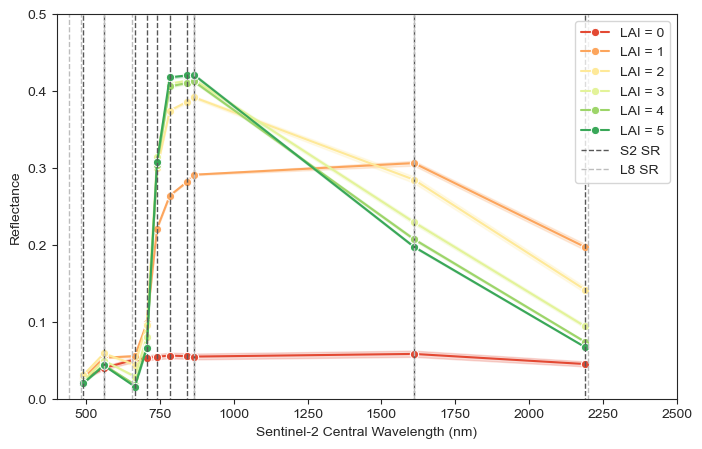

In [30]:
# path = 'C:/Users/mqalborn/Desktop/ET_3SEB/PISTACHIO/results/BLS_BANDS_TS.csv'
# bands_data, bands_data_melt = read_csv(path)

path = 'C:/Users/mqalborn/Desktop/ET_3SEB/Sentinel2_description.csv'
S2_info = pd.read_csv(path)
S2_info = S2_info[S2_info.band.isin(['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12'])]
S2_info = S2_info.astype({'Central Wavelength (nm)': int})

path = 'C:/Users/mqalborn/Desktop/ET_3SEB/Landsat8_description.csv'
L8_info = pd.read_csv(path)


sns.set_style('ticks')
sns.set_palette('RdYlGn')
plt.figure(figsize=(8, 5))
g1 = sns.lineplot(data=data_S2SRF, x='Central Wavelength (nm)', y='rho', marker='o', hue='LAI')
# g2 = sns.lineplot(data=bands_data_melt, x='Central Wavelength (nm)', y='rho', marker='o', label='Sentinel-2',
#                   color='grey', linestyle='--')
g1.vlines(
    x=S2_info['Central Wavelength (nm)'],
    ymin=g1.get_ylim()[0],
    ymax=0.5,
    color='#575757',
    linestyles='--',
    linewidth=1, label='S2 SR'
)

g1.vlines(
    x=L8_info['Central Wavelength (nm)'],
    ymin=g1.get_ylim()[0],
    ymax=0.5,
    color='#bdbdbd',
    linestyles='--',
    linewidth=1,  label='L8 SR'
)

g1.set(xlim=(400, 2500), ylim=(0, 0.5), xlabel='Sentinel-2 Central Wavelength (nm)', ylabel='Reflectance')
plt.legend(title=False)
plt.savefig(rf'C:\Users\mqalborn\Desktop\ET_3SEB\figures/vegetation_spectral_signature_S2SRF.jpg',
            dpi=300,
            bbox_inches='tight')

,band,Resolution (m),Central Wavelength (nm),Description
1,B02,10,490,Blue
2,B03,10,560,Green
3,B04,10,665,Red
4,B05,20,705,Visible and Near Infrared (VNIR)
5,B06,20,740,Visible and Near Infrared (VNIR)
6,B07,20,783,Visible and Near Infrared (VNIR)
7,B08,10,842,Visible and Near Infrared (VNIR)
8,B8A,20,865,Visible and Near Infrared (VNIR)
11,B11,20,1610,Short Wave Infrared (SWIR)
12,B12,20,2190,Short Wave Infrared (SWIR)


In [6]:
path = 'C:/Users/mqalborn/Desktop/ET_3SEB/Sentinel2_description.csv'
S2_info = pd.read_csv(path)
S2_info = S2_info.astype({'Central Wavelength (nm)': int})


,band,Resolution (m),Central Wavelength (nm),Description
0,B01,60,443,Ultra Blue (Coastal and Aerosol)
1,B02,10,490,Blue
2,B03,10,560,Green
3,B04,10,665,Red
4,B05,20,705,Visible and Near Infrared (VNIR)


In [145]:
# data_S2SRF = data_S2SRF.drop(['band'], axis=1)
data = data.rename(columns={'band': 'Central Wavelength (nm)'})

In [ ]:
sns.color_palette('RdYlGn')

In [180]:
# data_S2SRF = data_S2SRF.rename(columns={'band': 'Central Wavelength (nm)'})
outpath = rf'C:\Users\mqalborn\Desktop\ET_3SEB\figures/vegetation_spectral_signature_BLS.html'
plot_scroll_with_static(bands_data_melt, data, x='Central Wavelength (nm)', y='rho',
                        color='block', static_group='LAI', outpath=outpath)

#e34933
#fca55d
#fee999
#e3f399
#9dd569
#39a758


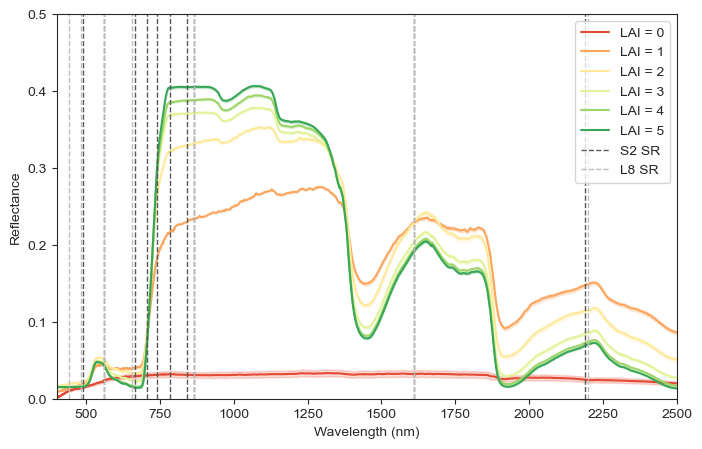

In [34]:
plt.figure(figsize=(8, 5))
sns.set_style('ticks')
g = sns.lineplot(data=data, x='band', y='rho', hue='LAI')
# g = sns.lineplot(data=bands_data_melt, x='Central Wavelength (nm)', y='rho', marker='o', label='Sentinel-2',
#                   color='grey', linestyle='--')
g.set(xlim=(400, 2500), ylim=(0, 0.5), xlabel='Wavelength (nm)', ylabel='Reflectance')

g.vlines(
    x=S2_info['Central Wavelength (nm)'],
    ymin=g1.get_ylim()[0],
    ymax=0.5,
    color='#575757',
    linestyles='--',
    linewidth=1, label='S2 SR'
)

g.vlines(
    x=L8_info['Central Wavelength (nm)'],
    ymin=g1.get_ylim()[0],
    ymax=0.5,
    color='#bdbdbd',
    linestyles='--',
    linewidth=1,  label='L8 SR'
)

plt.legend(title=False)
# plt.show()
plt.savefig(rf'C:\Users\mqalborn\Desktop\ET_3SEB\figures/vegetation_spectral_signature.jpg',
            dpi=300,
            bbox_inches='tight')

# path = 'C:/Users/mqalborn/Desktop/ET_3SEB/PISTACHIO/results/BLS_BANDS_TS.csv'
# bands_data, bands_data_melt = read_csv(path)